In [1]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
from keras.utils.vis_utils import plot_model
np.random.seed(20)   
tf.random.set_seed(20)

In [2]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [4]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel(),'physics_out':data1['physics_out'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(),'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','V_filt','Time','V','SS','physics_out']]
df_SS = df[['freqQAmpI_filt', 'C_filt', 'SS']] 
df_V = df[['freqQAmpI_filt', 'C_filt', 'V_filt']] 
df_PhyOut = df[['freqQAmpI_filt', 'C_filt', 'physics_out']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         freqQAmpI_filt       C_filt
0         31453.223522  5490.232850
1         31438.277060  5490.239343
2         31421.341616  5490.240838
3         31409.798761  5490.232728
4         31398.815589  5490.222463
...                ...          ...
132394    31055.686766  5457.051859
132395    31041.955345  5457.082380
132396    31035.059531  5457.111463
132397    31020.001291  5457.126443
132398    31012.016780  5457.151945

[132399 rows x 2 columns]
Target Data:
               SS    V_filt
0       5.656166  1.201004
1       5.657157  1.243144
2       5.658317  1.264215
3       5.659499  1.243144
4       5.660404  1.222074
...          ...       ...
132394  5.471059  1.285285
132395  5.474545  0.948161
132396  5.478286  1.158863
132397  5.481751  1.201004
132398  5.484813  0.526756

[132399 rows x 2 columns]


In [5]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (Physics_Out)
arr = df_PhyOut.to_numpy()
n_steps = 300
xdf, phy_outdf = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))
print('Target shape (Physics_Out), Y = ', np.shape(phy_outdf))

# Reshape 
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 2)
Target shape (SS), Y =  (132099,)
Target shape (V), Y =  (132099,)
Target shape (Physics_Out), Y =  (132099,)
After reshaping, X =  (132099, 600)


In [6]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Split into train-val-test (Physics Out)
x_train, x_test, y_train_Phy, y_test_Phy = train_test_split(xdf, phy_outdf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_Phy, Y_val_Phy = train_test_split(x_train, y_train_Phy, test_size=0.125, shuffle=False)

# Select Train
X_train = X_train[13210:92469]  
Y_train_SS = Y_train_SS[13210:92469]
Y_train_V = Y_train_V[13210:92469]
Y_train_Phy = Y_train_Phy[13210:92469]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 79259
Validation samples: 13210
Testing samples: 26420


In [7]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [8]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

In [9]:
# Time derivative function
ss1 = 0
def Time_Derivative(del_t,ss2):
    global ss1
    Gradient_Value = (ss2 - ss1) / (del_t)
    ss1 = ss2
    return Gradient_Value

**Define Physics-Informed Model**: **Self Learning Constants**

In [10]:
# Define Physics
class gradient_1(tf.keras.layers.Layer):
  def __init__(self):
    super(gradient_1,self).__init__()
    self.SS = tf.keras.layers.Dense(1)
    self.V = tf.keras.layers.Dense(1)
    self.all_scale = tf.keras.layers.Dense(1)
    self.c1 = self.add_weight("c1",trainable=True)
    self.c2 = self.add_weight("c2",trainable=True)
    self.c3 = self.add_weight("c3",trainable=True)

  def call(self, params):
    ss_pred, v_pred = params 
    ss_pred = self.SS(ss_pred)
    v_pred = self.V(v_pred)

    term1 = Time_Derivative(0.01,ss_pred)
    term2 = tf.divide(1,self.c1)
    term3 = tf.multiply(term1,term2)
    term4 = (self.c2-v_pred)
    term5 = tf.multiply(self.c3,term4)
    eqn = term3-term5
    eqn = self.all_scale(eqn)

    return eqn

In [11]:
# Define PINN
def MLP_Physics():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')   

  # Shear Stress + Slip Rate model
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  grad_out = gradient_1()([ss_pred,v_pred])
  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred,grad_out])
  return model

In [12]:
# Model Summary
model=MLP_Physics()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

Train on 79259 samples, validate on 13210 samples
Epoch 1/100
79168/79259 [============================>.] - ETA: 0s - loss: 0.5162 - dense_5_loss: 0.5052 - dense_6_loss: 0.0094 - gradient_1_loss: 0.0016 - dense_5_mse: 0.5052 - dense_6_mse: 0.0094 - gradient_1_mse: 0.0016

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


79259/79259 [==============================] - 11s 133us/sample - loss: 0.5161 - dense_5_loss: 0.5052 - dense_6_loss: 0.0094 - gradient_1_loss: 0.0016 - dense_5_mse: 0.5052 - dense_6_mse: 0.0094 - gradient_1_mse: 0.0016 - val_loss: 0.4042 - val_dense_5_loss: 0.3896 - val_dense_6_loss: 0.0147 - val_gradient_1_loss: 5.3070e-06 - val_dense_5_mse: 0.3896 - val_dense_6_mse: 0.0147 - val_gradient_1_mse: 5.3069e-06
Epoch 2/100
79259/79259 [==============================] - 8s 106us/sample - loss: 0.3466 - dense_5_loss: 0.3363 - dense_6_loss: 0.0094 - gradient_1_loss: 9.1647e-04 - dense_5_mse: 0.3363 - dense_6_mse: 0.0094 - gradient_1_mse: 9.1648e-04 - val_loss: 0.1837 - val_dense_5_loss: 0.1690 - val_dense_6_loss: 0.0146 - val_gradient_1_loss: 4.0795e-05 - val_dense_5_mse: 0.1690 - val_dense_6_mse: 0.0146 - val_gradient_1_mse: 4.0797e-05
Epoch 3/100
79259/79259 [==============================] - 7s 94us/sample - loss: 0.0255 - dense_5_loss: 0.0148 - dense_6_loss: 0.0093 - gradient_1_loss: 0.0

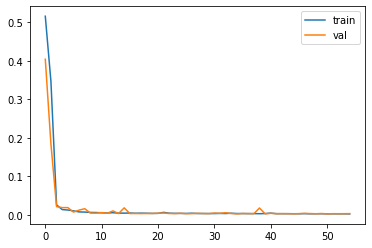

---Training time: 486.04240298 seconds ---


In [13]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')  
callbacks_list = [earlystop]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V,Y_train_Phy], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V,Y_val_Phy]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# # Save the model
# print(model.summary())
# plot_model(model, show_shapes=True)
# model.save('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/Reference_p5270/PINN_1/PINN_Transfer_model_70_10_20.h5')

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing 
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.96972, Train (V) - 0.87545
R2 scores: Validation (SS) - 0.97659, Validation (V) - 0.91454
R2 scores: Testing (SS) - 0.94149, Testing (V) - 0.84004
RMSE scores: Train (SS) - 0.02921, Train (V) - 0.03411
RMSE scores: Validation (SS) - 0.02928, Validation (V) - 0.03538
RMSE scores: Testing (SS) - 0.04537, Testing (V) - 0.04703


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

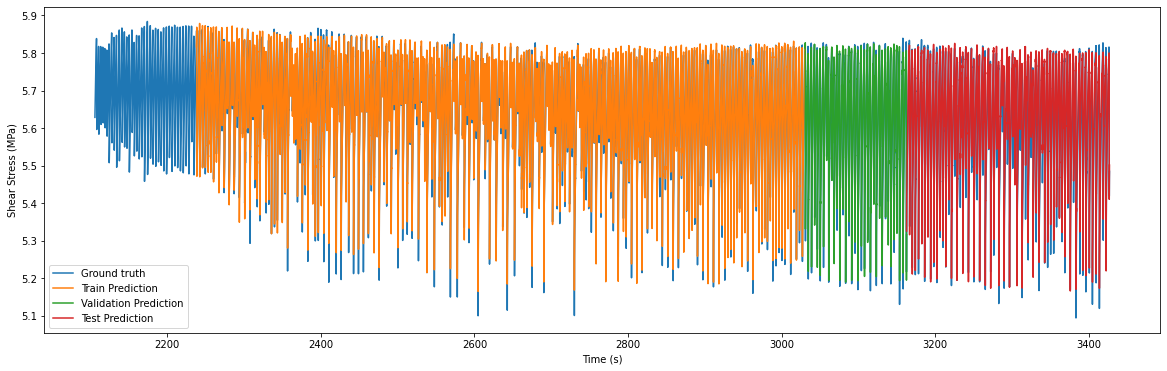

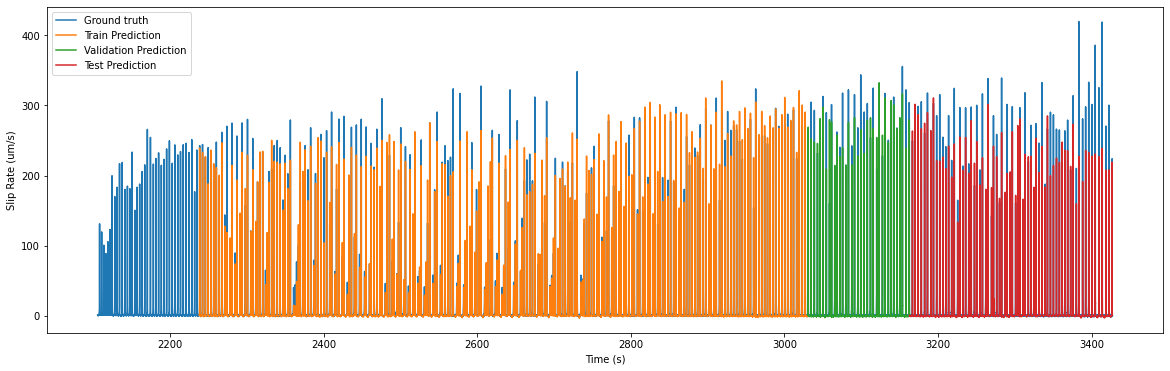

In [ ]:
# Overall plot: SS & V 
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[13210:92469]

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

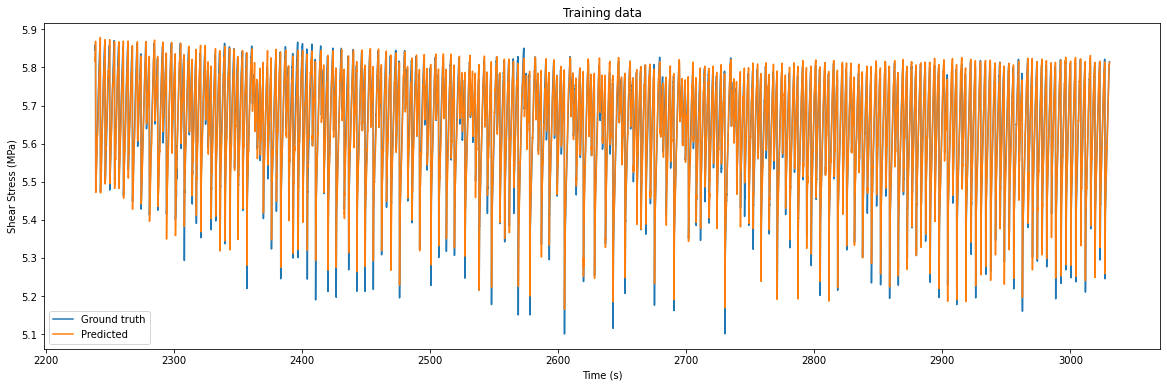

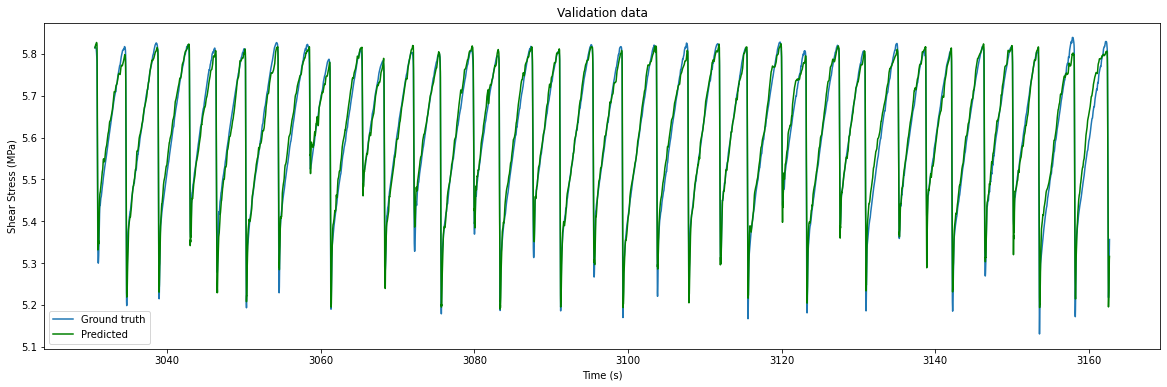

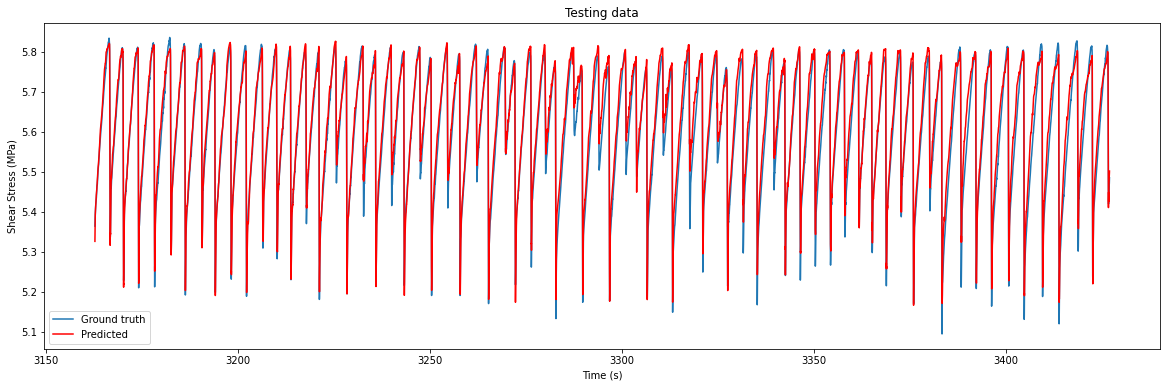

In [ ]:
# Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

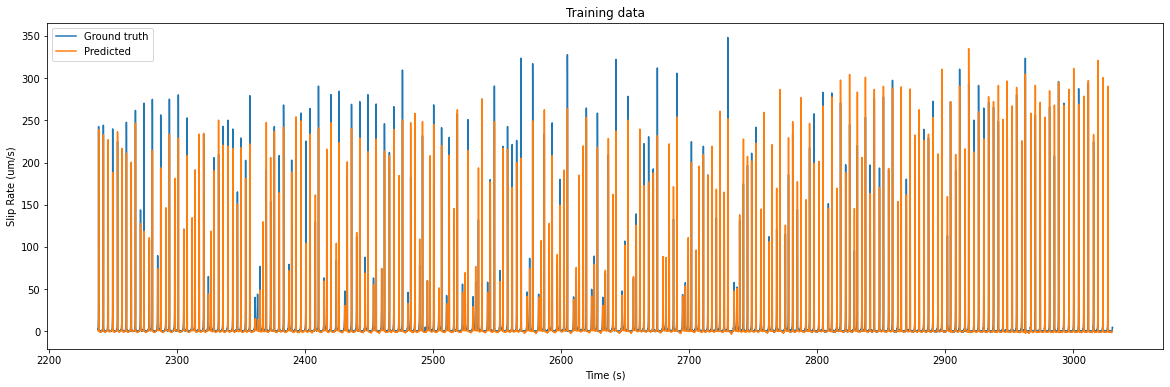

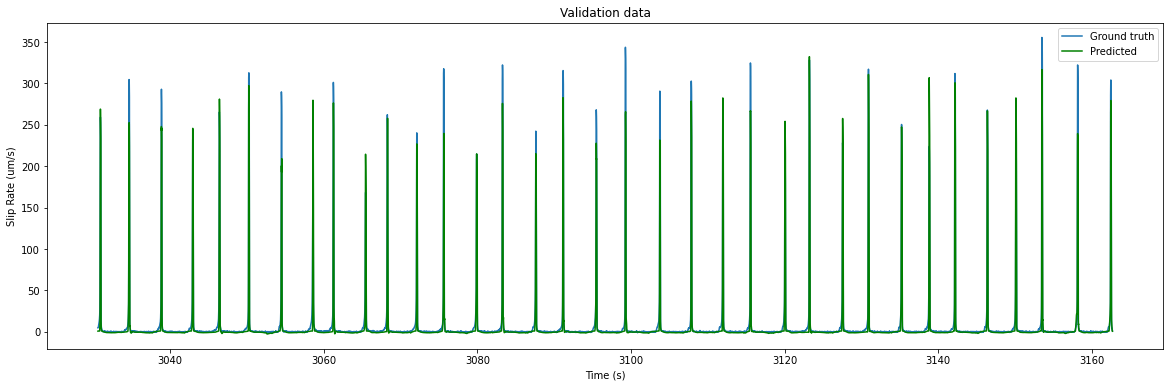

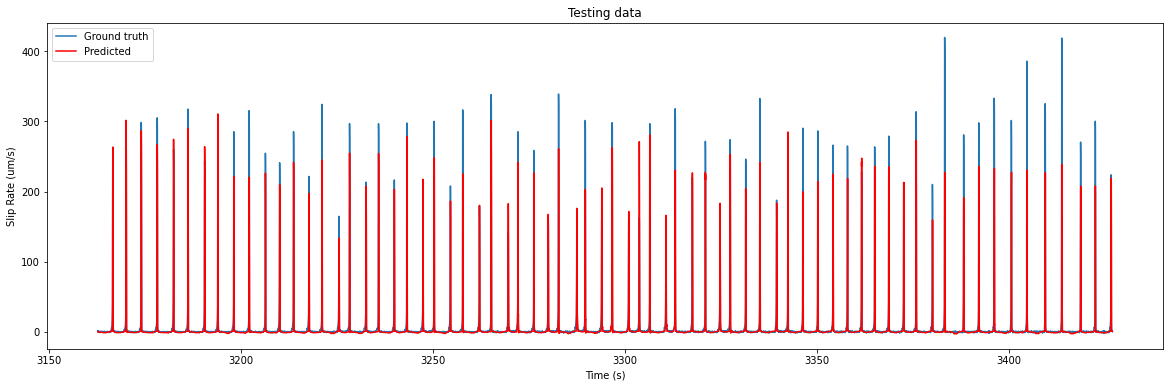

In [ ]:
# Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')

In [ ]:
# Extarct Weights
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

for name, weight in zip(names, weights):
    print(name, weight.shape)

dense/kernel:0 (600, 128)
dense/bias:0 (128,)
dense_1/kernel:0 (128, 64)
dense_1/bias:0 (64,)
dense_2/kernel:0 (64, 32)
dense_2/bias:0 (32,)
dense_3/kernel:0 (32, 16)
dense_3/bias:0 (16,)
dense_4/kernel:0 (16, 8)
dense_4/bias:0 (8,)
dense_5/kernel:0 (8, 1)
dense_5/bias:0 (1,)
dense_6/kernel:0 (8, 1)
dense_6/bias:0 (1,)
c1:0 ()
c2:0 ()
c3:0 ()
gradient_1/dense_7/kernel:0 (1, 1)
gradient_1/dense_7/bias:0 (1,)
gradient_1/dense_8/kernel:0 (1, 1)
gradient_1/dense_8/bias:0 (1,)
gradient_1/dense_9/kernel:0 (1, 1)
gradient_1/dense_9/bias:0 (1,)


In [ ]:
# Display Weights
model.get_weights()

[array([[-0.08498019,  0.02607526,  0.06209034, ..., -0.02633831,
         -0.00419845,  0.02071179],
        [-0.07576513,  0.00021532,  0.02195152, ...,  0.11222209,
          0.00065739, -0.01933127],
        [-0.01546091,  0.00179103, -0.01570304, ..., -0.04294511,
         -0.10020287, -0.07088165],
        ...,
        [ 0.04960544,  0.03033755, -0.00487585, ...,  0.10497186,
         -0.045948  , -0.01282755],
        [ 0.05493801,  0.03242324,  0.00612776, ..., -0.01788392,
         -0.01224912, -0.02632119],
        [-0.06132267,  0.00391166,  0.02218693, ...,  0.05658801,
          0.0571263 , -0.06338484]], dtype=float32),
 array([ 1.10163778e-01, -5.25534619e-03, -5.87141793e-03, -6.12340029e-03,
        -7.16435583e-03, -5.83893713e-03, -6.94931950e-03, -6.00428833e-03,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -6.00633910e-03,
         9.95083451e-02, -6.60773413e-03, -1.61958218e-03, -3.81129142e-03,
        -5.97712351e-03, -5.99870831e-03,  0.00000000e

In [ ]:
# ML Learned Constants

# Normal Stress
r1 = 10/5.89
cols = ['NS']
data = pd.DataFrame(np.array([[-2.20]]),columns=cols)
NS = scaler_ss.inverse_transform(data)
NS = (NS*r1)*r1

# Shear Loading Velocity
dt = 0.01
cols = ['VL']
data = pd.DataFrame(np.array([[1.11]]),columns=cols)
VL = scaler_v.inverse_transform(data)
VL = (VL*dt)*r1

# Stiffness
k = (0.24*dt)*r1*r1

print("Normal Stress:",NS)
print("Shear Loading Velocity:",VL)
print("Stiffness:",k)

Normal Stress: [[9.81549196]]
Shear Loading Velocity: [[6.5629475]]
Stiffness: 0.006918001504665327


In [ ]:
# # Extract Data

# # Time 
# savetxt('Whole_time.csv', ttime, delimiter=',')
# savetxt('traintime.csv', traintime, delimiter=',')
# savetxt('valtime.csv', valtime, delimiter=',')
# savetxt('testtime.csv', testtime, delimiter=',')

# # SS
# savetxt('Y_train_SS.csv', Y_train_SS, delimiter=',')
# savetxt('Y_val_SS.csv', Y_val_SS, delimiter=',')
# savetxt('y_test_SS.csv', y_test_SS, delimiter=',')
# savetxt('y_predtrain_SS.csv', y_predtrain_SS, delimiter=',')
# savetxt('y_predval_SS.csv', y_predval_SS, delimiter=',')
# savetxt('y_predtest_SS.csv', y_predtest_SS, delimiter=',')

# # V
# savetxt('Y_train_V.csv', Y_train_V, delimiter=',')
# savetxt('Y_val_V.csv', Y_val_V, delimiter=',')
# savetxt('y_test_V.csv', y_test_V, delimiter=',')
# savetxt('y_predtrain_V.csv', y_predtrain_V, delimiter=',')
# savetxt('y_predval_V.csv', y_predval_V, delimiter=',')
# savetxt('y_predtest_V.csv', y_predtest_V, delimiter=',')

# # Download
# files.download('Whole_time.csv')
# files.download('traintime.csv')
# files.download('valtime.csv')
# files.download('testtime.csv')

# files.download('Y_train_SS.csv')
# files.download('Y_val_SS.csv')
# files.download('y_test_SS.csv')
# files.download('y_predtrain_SS.csv')
# files.download('y_predval_SS.csv')
# files.download('y_predtest_SS.csv')

# files.download('Y_train_V.csv')
# files.download('Y_val_V.csv')
# files.download('y_test_V.csv')
# files.download('y_predtrain_V.csv')
# files.download('y_predval_V.csv')
# files.download('y_predtest_V.csv')